In [1]:
import pandas as pd
from tqdm import tqdm
import os

# 定义与中风相关的 ICD 代码
stroke_icd_codes = [
    # ICD-10 相关代码
    'I60', 'I61', 'I62', 'I63', 'I65', 'I66',  # 非创伤性蛛网膜下腔出血、脑内出血等
    'I603', 'I604', 'I605', 'I606', 'I607', 'I608', 'I609',  # 其他相关的蛛网膜下腔出血
    'I620', 'I6200', 'I6201', 'I6202', 'I6203',  # 硬膜下出血
    'I621',  # 硬膜外出血
    'I62',  # 其他和未特指的非创伤性颅内出血
    'I63', 'I630', 'I6300', 'I6301', 'I6302', 'I6303', 'I631', 'I6310', 'I6311', 'I6312', 'I6313',  # 脑梗塞相关代码
    'I634', 'I6340', 'I6341', 'I6342', 'I6343',  # 脑栓塞相关代码
    'I635', 'I6350', 'I6351', 'I6352', 'I6353',  # 脑动脉闭塞和狭窄
    'I636', 'I638', 'I639',  # 其他脑梗塞
    'G45', 'G450', 'G451', 'G452', 'G453', 'G454', 'G458', 'G459',  # 短暂性脑缺血发作相关综合症

    # ICD-9 相关代码
    '430', '431', '4320', '4321', '4329',  # 蛛网膜下腔出血、脑内出血等
    '43300', '43301', '43310', '43311', '43320', '43321', '43330', '43331',  # 动脉闭塞和狭窄
    '43380', '43381', '43390', '43391',  # 其他动脉闭塞
    '43400', '43401', '43410', '43411',  # 脑血栓和脑栓塞
    '43490', '43491',  # 未特指的脑动脉闭塞
    '4350', '4351', '4352', '4353', '4358', '4359',  # 短暂性脑缺血
    '436'  # 急性但未明确的脑血管疾病
]

# 读取 CSV 文件
input_file_path = '../diagnoses_icd.csv' 
output_file_path = 'output/Stroke_Patients.csv'  # 输出文件路径

os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# 显示进度条
tqdm.pandas(desc="Filtering stroke patients")

# 分块读取数据
chunk_size = 10000  
filtered_chunks = []  

for chunk in pd.read_csv(input_file_path, chunksize=chunk_size):
    # 过滤出与中风相关的 ICD 代码
    filtered_chunk = chunk[chunk['icd_code'].astype(str).isin(stroke_icd_codes)]
    filtered_chunks.append(filtered_chunk)

# 合并所有过滤后的数据块
filtered_df = pd.concat(filtered_chunks, ignore_index=True)
result_df = filtered_df[['subject_id', 'hadm_id', 'icd_code', 'icd_version']]

result_df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")

# 打印中风病人的数量
print(f"Stroke patients: {result_df.shape[0]}")

Filtered data saved to output/Stroke_Patients.csv
Stroke patients: 17287


In [2]:
import pandas as pd
import os

# 读取中风病人信息
stroke_patient_info = pd.read_csv(os.path.join('output', 'Stroke_Patients.csv'))

# 读取 icustays.csv 文件
icu_stay_data = pd.DataFrame()
chunksize = 100000

# 分块读取 icustays.csv
for chunk in pd.read_csv('../icustays.csv', chunksize=chunksize):
    # 根据 subject_id 和 hadm_id 进行连接
    merged_chunk = pd.merge(stroke_patient_info, chunk, on=['subject_id', 'hadm_id'], how='inner')
    
    # 提取所需字段并添加到结果 DataFrame
    icu_stay_data = pd.concat([icu_stay_data, merged_chunk[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'los']]], ignore_index=True)

# 保存结果到 Stroke_ICU.csv
output_folder = "output"
output_file_path_strokeicu = os.path.join(output_folder, 'Stroke_ICU.csv')
icu_stay_data.to_csv(output_file_path_strokeicu, index=False)

print(f"Stroke_ICU.csv 文件已保存到 {output_file_path_strokeicu}")

Stroke_ICU.csv 文件已保存到 output\Stroke_ICU.csv


In [4]:
import pandas as pd
import os

# 读取 Stroke_ICU.csv 文件
icu_stay_data = pd.read_csv(os.path.join('output', 'Stroke_ICU.csv'))

# 保留首次住院 ICU 的病人记录
icu_stay_data_first = icu_stay_data.drop_duplicates(subset='subject_id', keep='first')

# 删除 los 字段小于 30 的记录
icu_stay_data_first_30 = icu_stay_data_first[icu_stay_data_first['los'] <= 30]

# 保存结果到 Stroke_ICU_First_30.csv
output_file_path_strokeicu_first_30 = os.path.join('output', 'Stroke_ICU_First_30.csv')
icu_stay_data_first_30.to_csv(output_file_path_strokeicu_first_30, index=False)

print(f"Stroke_ICU_First_30.csv 文件已保存到 {output_file_path_strokeicu_first_30}")

Stroke_ICU_First_30.csv 文件已保存到 output\Stroke_ICU_First_30.csv


In [5]:
import pandas as pd
import os
from tqdm import tqdm

# 读取 Stroke_ICU_First_30.csv 文件
icu_stay_data = pd.read_csv(os.path.join('output', 'Stroke_ICU_First_30.csv'))

# 读取 patients.csv 文件
patients_data = pd.read_csv('../patients.csv')

# 计算进入 ICU 时的年龄并添加性别字段
def calculate_age(row):
    # 计算年龄
    age = row['anchor_age'] + row['intime_year'] - row['anchor_year']
    return age

# 添加年份字段
icu_stay_data['intime_year'] = pd.to_datetime(icu_stay_data['intime']).dt.year

tqdm.pandas(desc="Calculating age and filtering patients")

merged_data = pd.merge(icu_stay_data, patients_data, on='subject_id', how='inner')
merged_data['age'] = merged_data.progress_apply(calculate_age, axis=1)

# 筛选年龄在 18 到 89 岁之间的记录
filtered_data = merged_data[(merged_data['age'] >= 18) & (merged_data['age'] <= 89)]

final_data = filtered_data[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'los', 'age', 'gender']]

output_file_path_stroke_age_gender = os.path.join('output', 'Stroke_Age_Gender.csv')
final_data.to_csv(output_file_path_stroke_age_gender, index=False)

print(f"Stroke_Age_Gender.csv 文件已保存到 {output_file_path_stroke_age_gender}")

Calculating age and filtering patients: 100%|██████████| 5818/5818 [00:00<00:00, 108246.59it/s]

Stroke_Age_Gender.csv 文件已保存到 output\Stroke_Age_Gender.csv


In [3]:
# Targets
import pandas as pd
from tqdm import tqdm

# 定义要保留的 itemid 列表
itemid_list = [
    220051, 220045, 220050, 220052, 225624, 220621, 220210, 226540, 223761,
    220228, 227428, 227073, 220277, 227457, 220615, 220546, 227467, 227442,
    220645, 227465, 220602, 227443, 227466, 220224, 220235, 224828
]

# 读取 Stroke_Age_Gender.csv 中的 subject_id
stroke_df = pd.read_csv('output/Stroke_Age_Gender.csv', usecols=['subject_id'])
stroke_subject_ids = set(stroke_df['subject_id'])

# 初始化一个空的 DataFrame 来存储结果
filtered_data = pd.DataFrame()

# 分块读取 chartevents.csv
chunk_size = 100000  # 根据需要调整块大小
total_rows = sum(1 for _ in open('../chartevents.csv')) - 1  # 计算总行数，减去标题行
with tqdm(total=total_rows, desc="Processing chartevents.csv") as pbar:
    for chunk in pd.read_csv('../chartevents.csv', chunksize=chunk_size):
        # 过滤条件：subject_id 在 stroke_subject_ids 中，且 itemid 在 itemid_list 中
        filtered_chunk = chunk[
            (chunk['subject_id'].isin(stroke_subject_ids)) &
            (chunk['itemid'].isin(itemid_list))
        ]
        # 将过滤后的数据追加到结果 DataFrame
        filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)
        # 更新进度条
        pbar.update(len(chunk))

# 将结果保存到 Targets_Raw.csv
filtered_data.to_csv('output/Targets_Raw.csv', index=False)

Processing chartevents.csv: 100%|██████████| 432997491/432997491 [17:39<00:00, 408746.08it/s]


In [4]:
# Goals
import pandas as pd
from tqdm import tqdm

# 定义要保留的 itemid 列表
itemid_list = [
   220739, 223900, 223901
]

# 读取 Stroke_Age_Gender.csv 中的 subject_id
stroke_df = pd.read_csv('output/Stroke_Age_Gender.csv', usecols=['subject_id'])
stroke_subject_ids = set(stroke_df['subject_id'])

# 初始化一个空的 DataFrame 来存储结果
filtered_data = pd.DataFrame()

# 分块读取 chartevents.csv
chunk_size = 100000  # 根据需要调整块大小
total_rows = sum(1 for _ in open('../chartevents.csv')) - 1  # 计算总行数，减去标题行
with tqdm(total=total_rows, desc="Processing chartevents.csv") as pbar:
    for chunk in pd.read_csv('../chartevents.csv', chunksize=chunk_size):
        # 过滤条件：subject_id 在 stroke_subject_ids 中，且 itemid 在 itemid_list 中
        filtered_chunk = chunk[
            (chunk['subject_id'].isin(stroke_subject_ids)) &
            (chunk['itemid'].isin(itemid_list))
        ]
        # 将过滤后的数据追加到结果 DataFrame
        filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)
        # 更新进度条
        pbar.update(len(chunk))

# 将结果保存到 Goals_Raw.csv
filtered_data.to_csv('output/Goals_Raw.csv', index=False)

Processing chartevents.csv: 100%|██████████| 432997491/432997491 [31:21<00:00, 230128.91it/s]


In [5]:
import pandas as pd
from tqdm import tqdm

# 读取 Stroke_Age_Gender.csv 文件
stroke_age_gender_data = pd.read_csv('output/Stroke_Age_Gender.csv', usecols=['subject_id', 'intime', 'age', 'gender'])

# 初始化一个空的 DataFrame 来存储结果
final_data = pd.DataFrame()

# 分块读取 Targets_Raw.csv
chunk_size = 10000  # 根据需要调整块大小
total_rows = sum(1 for _ in open('output/Targets_Raw.csv')) - 1  # 计算总行数，减去标题行
with tqdm(total=total_rows, desc="Merging data") as pbar:
    for chunk in pd.read_csv('output/Targets_Raw.csv', chunksize=chunk_size):
        # 合并数据，添加 intime、age 和 gender 列
        merged_chunk = pd.merge(chunk, stroke_age_gender_data, on='subject_id', how='left')
        # 选择需要的列
        merged_chunk = merged_chunk[['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valuenum', 'valueuom', 'intime', 'age', 'gender']]
        # 将合并后的数据追加到结果 DataFrame
        final_data = pd.concat([final_data, merged_chunk], ignore_index=True)
        # 更新进度条
        pbar.update(len(chunk))

# 保存结果到 Targets_with_Info.csv
output_file_path_targets_with_info = 'output/Targets_with_Info.csv'
final_data.to_csv(output_file_path_targets_with_info, index=False)

print(f"Targets_with_Info.csv 文件已保存到 {output_file_path_targets_with_info}")

Merging data: 100%|██████████| 5418324/5418324 [01:07<00:00, 80790.65it/s] 


Targets_with_Info.csv 文件已保存到 output/Targets_with_Info.csv


In [8]:
import pandas as pd
from tqdm import tqdm

# 读取 Targets_with_Info.csv 文件
targets_with_info = pd.read_csv('output/Targets_with_Info.csv')

# 读取 Stroke_Normal_Data.csv 文件
normal_data = pd.read_csv('output/Stroke_Normal_Data.csv')

# 创建一个字典来快速查找正常范围
normal_ranges = normal_data.set_index('itemid').T.to_dict()

# 定义一个函数来计算 tag
def calculate_tag(row):
    itemid = row['itemid']
    value = row['value']
    gender = row['gender']
    
    if itemid in normal_ranges:
        if gender == 'M':
            low, high = normal_ranges[itemid]['M_low'], normal_ranges[itemid]['M_high']
        else:
            low, high = normal_ranges[itemid]['F_low'], normal_ranges[itemid]['F_high']
        
        if low <= value <= high:
            return 'Normal'
        elif value < low:
            return 'Low'
        else:
            return 'High'
    return 'unknown'

# 使用 tqdm 显示进度条
tqdm.pandas(desc="Calculating tags")

# 计算 tag 列
targets_with_info['tag'] = targets_with_info.progress_apply(calculate_tag, axis=1)

# 过滤出 tag 不为 Normal 的行
filtered_targets = targets_with_info[targets_with_info['tag'] != 'Normal']

# 保存结果到 Targets_with_Tag.csv
output_file_path_targets_with_tag = 'output/Targets_with_Tag.csv'
filtered_targets.to_csv(output_file_path_targets_with_tag, index=False)

print(f"Targets_with_Tag.csv 文件已保存到 {output_file_path_targets_with_tag}")

Calculating tags: 100%|██████████| 5418324/5418324 [00:36<00:00, 148019.11it/s]


Targets_with_Tag.csv 文件已保存到 output/Targets_with_Tag.csv


In [9]:
import pandas as pd
from tqdm import tqdm

# 读取 Targets_with_Tag.csv 文件
targets_with_tag = pd.read_csv('output/Targets_with_Tag.csv')

# 读取 Stroke_Normal_Data.csv 文件
normal_data = pd.read_csv('output/Stroke_Normal_Data.csv')

# 创建一个字典来快速查找 label
label_dict = normal_data.set_index('itemid')['label'].to_dict()

# 定义一个函数来计算 event
def calculate_event(row):
    itemid = row['itemid']
    tag = row['tag']
    
    if itemid in label_dict:
        label = label_dict[itemid]
        return f"{label} {tag}"
    return 'unknown'

# 定义一个函数来计算 time
def calculate_time(row):
    charttime = pd.to_datetime(row['charttime'])
    intime = pd.to_datetime(row['intime'])
    time_diff = charttime - intime
    return time_diff.total_seconds() / 3600  # 转换为小时

# 使用 tqdm 显示进度条
tqdm.pandas(desc="Calculating events and times")

# 计算 event 列
targets_with_tag['event'] = targets_with_tag.progress_apply(calculate_event, axis=1)

# 计算 time 列
targets_with_tag['time'] = targets_with_tag.progress_apply(calculate_time, axis=1)

# 保存结果到 Targets_All.csv
output_file_path_targets_all = 'output/Targets_All.csv'
targets_with_tag.to_csv(output_file_path_targets_all, index=False)

print(f"Targets_All.csv 文件已保存到 {output_file_path_targets_all}")

Calculating events and times: 100%|██████████| 2051936/2051936 [19:28<00:00, 1755.73it/s]


Targets_All.csv 文件已保存到 output/Targets_All.csv


In [12]:
import pandas as pd

# 读取 Targets_All.csv 文件
targets_all = pd.read_csv('output/Targets_All.csv')

# 选择并重命名所需的列
final_data = targets_all[['stay_id', 'time', 'value', 'event']].rename(
    columns={'stay_id': 'id', 'time': 't', 'value': 'v', 'event': 'k'}
)

# 按照 id 和 t 进行排序
final_data = final_data.sort_values(by=['id', 't'])

# 去除连续出现的 k 值相同的行，只保留第一行
final_data = final_data.loc[final_data['k'].shift() != final_data['k']]

# 保存结果到 Targets_Final_Unique.csv
output_file_path_targets_final = 'output/Targets_Final_Unique.csv'
final_data.to_csv(output_file_path_targets_final, index=False)

print(f"Targets_Final_Unique.csv 文件已保存到 {output_file_path_targets_final}")

Targets_Final_Unique.csv 文件已保存到 output/Targets_Final_Unique.csv


In [14]:
import pandas as pd

# 读取 Targets_Final.csv 文件
targets_final = pd.read_csv('output/Goal_Middle_to_Sever.csv')

# 提取唯一的 stay_id，并排序
unique_stay_ids = targets_final['stay_id'].unique()
sorted_stay_ids = sorted(unique_stay_ids)

# 创建 DataFrame 存储结果
useful_data = pd.DataFrame(sorted_stay_ids, columns=['stay_id'])

# 保存结果到 Useful_Middle_to_Sever.csv
output_file_path_useful = 'output/Useful_Middle_to_Sever.csv'
useful_data.to_csv(output_file_path_useful, index=False)

print(f"Useful_Middle_to_Sever.csv 文件已保存到 {output_file_path_useful}")

Useful_Middle_to_Sever.csv 文件已保存到 output/Useful_Middle_to_Sever.csv


In [16]:
import pandas as pd
from tqdm import tqdm

# 读取 Targets_Final_Unique.csv 文件
targets_final_unique = pd.read_csv('output/Targets_Final_Unique.csv')

# 读取 Useful_Middle_to_Sever.csv 文件
useful_stay_ids = pd.read_csv('output/Useful_Middle_to_Sever.csv')

# 将 stay_id 列转换为集合以便快速查找
useful_stay_id_set = set(useful_stay_ids['stay_id'])

# 使用 tqdm 显示进度条
tqdm.pandas(desc="Filtering rows")

# 过滤数据
filtered_data = targets_final_unique[targets_final_unique['id'].progress_apply(lambda x: x in useful_stay_id_set)]

# 删除 t 值为负数的行
filtered_data = filtered_data[filtered_data['t'] >= 0]

# 保存结果到 Targets_Middle_to_Sever.csv
output_file_path_targets_middle_to_sever = 'output/Targets_Middle_to_Sever.csv'
filtered_data.to_csv(output_file_path_targets_middle_to_sever, index=False)

print(f"Targets_Middle_to_Sever.csv 文件已保存到 {output_file_path_targets_middle_to_sever}")

Filtering rows: 100%|██████████| 1830068/1830068 [00:01<00:00, 1609691.36it/s]


Targets_Middle_to_Sever.csv 文件已保存到 output/Targets_Middle_to_Sever.csv


In [18]:
import pandas as pd

# 读取 Targets_Middle_to_Sever.csv 文件
targets_middle_to_sever = pd.read_csv('output/Goal_Middle_to_Sever.csv')

# 重命名 stay_id 列为 id
targets_middle_to_sever.rename(columns={'stay_id': 'id'}, inplace=True)

# 将 charttime 和 intime 转换为 datetime 格式
targets_middle_to_sever['charttime'] = pd.to_datetime(targets_middle_to_sever['charttime'])
targets_middle_to_sever['intime'] = pd.to_datetime(targets_middle_to_sever['intime'])

# 计算时间差并转换为小时
targets_middle_to_sever['t'] = (targets_middle_to_sever['charttime'] - targets_middle_to_sever['intime']).dt.total_seconds() / 3600

# 将 score 列替换为 v
targets_middle_to_sever.rename(columns={'score': 'v'}, inplace=True)

# 新增 k 列
targets_middle_to_sever['k'] = 'Middle_to_Sever'

# 删除 t 值小于0的行
targets_middle_to_sever = targets_middle_to_sever[targets_middle_to_sever['t'] >= 0]

# 选择需要的列并保存结果到 Goals.csv
final_columns = ['id', 't', 'v', 'k']
goals_data = targets_middle_to_sever[final_columns]

# 保存结果到 Goals.csv
output_file_path_goals = 'output/Goals.csv'
goals_data.to_csv(output_file_path_goals, index=False)

print(f"Goals.csv 文件已保存到 {output_file_path_goals}")

Goals.csv 文件已保存到 output/Goals.csv


In [22]:
import pandas as pd

# 读取 Goals.csv 文件
goals_data = pd.read_csv('output/Goals.csv')

# 读取 Targets_Middle_to_Sever.csv 文件
targets_middle_to_sever = pd.read_csv('output/Targets_Middle_to_Sever.csv')

# 合并两个 DataFrame
combined_data = pd.concat([goals_data, targets_middle_to_sever], ignore_index=True)

# 按照 id 和 t 进行排序
combined_data = combined_data.sort_values(by=['id', 't'])

# 保存结果到 Stroke_Dataset.csv
output_file_path_stroke_dataset = 'output/Stroke_raw_Dataset.csv'
combined_data.to_csv(output_file_path_stroke_dataset, index=False)

print(f"Stroke_raw_Dataset.csv 文件已保存到 {output_file_path_stroke_dataset}")

Stroke_raw_Dataset.csv 文件已保存到 output/Stroke_raw_Dataset.csv


In [26]:
import pandas as pd
from tqdm import tqdm

# 读取 Stroke_Dataset.csv 文件
stroke_dataset = pd.read_csv('output/Stroke_raw_Dataset.csv')

# 初始化一个空的 DataFrame 来存储结果
filtered_data = pd.DataFrame()

# 遍历每个唯一的 id，使用 tqdm 显示进度
for unique_id in tqdm(stroke_dataset['id'].unique(), desc="Processing IDs"):
    # 获取当前 id 的所有行
    id_data = stroke_dataset[stroke_dataset['id'] == unique_id]
    
    # 找到 k 值为 Middle_to_Sever 的最后一行
    middle_to_sever_last_index = id_data[id_data['k'] == 'Middle_to_Sever'].index.max()
    
    # 如果找到了最后一行，保留该行及其之前的所有行
    if middle_to_sever_last_index is not None:
        filtered_data = pd.concat([filtered_data, id_data.loc[:middle_to_sever_last_index]])

# 删除 v 值为负数的行
filtered_data = filtered_data[filtered_data['v'] >= 0]

# 保存结果到 Stroke_Dataset_Filtered.csv
output_file_path_stroke_dataset_filtered = 'output/Stroke_Dataset.csv'
filtered_data.to_csv(output_file_path_stroke_dataset_filtered, index=False)

print(f"Stroke_Dataset.csv 文件已保存到 {output_file_path_stroke_dataset_filtered}")

Processing IDs: 100%|██████████| 1362/1362 [00:07<00:00, 178.32it/s]


Stroke_Dataset.csv 文件已保存到 output/Stroke_Dataset.csv


总序列数量: 4602


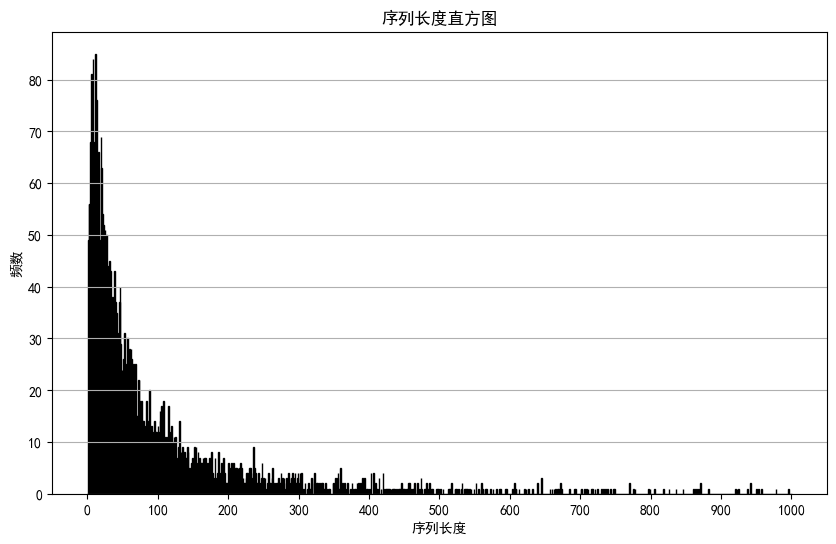

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体以显示中文
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取 Stroke_Dataset_Filtered.csv 文件
stroke_dataset_filtered = pd.read_csv('output/Stroke_Dataset.csv')

# 找到所有 k 值为 Middle_to_Sever 的行的索引
middle_to_sever_indices = stroke_dataset_filtered[stroke_dataset_filtered['k'] == 'Middle_to_Sever'].index

# 计算序列数量和长度
sequence_lengths = []
for i in range(len(middle_to_sever_indices) - 1):
    start_index = middle_to_sever_indices[i]
    end_index = middle_to_sever_indices[i + 1]
    sequence_length = end_index - start_index - 1  # 不包括两个 Middle_to_Sever 行
    if sequence_length > 0:
        sequence_lengths.append(sequence_length)

# 统计序列数量
total_sequences = len(sequence_lengths)

# 打印序列数量
print(f"总序列数量: {total_sequences}")

# 绘制序列长度的直方图
plt.figure(figsize=(10, 6))
plt.hist([length for length in sequence_lengths if length <= 1000], bins=range(0, 1002), edgecolor='black', align='left')
plt.title('序列长度直方图')
plt.xlabel('序列长度')
plt.ylabel('频数')
plt.xticks(range(0, 1001, 100))  # 横坐标标记为100, 200, 300, ..., 1200
plt.grid(axis='y')
plt.show()

In [15]:
import pandas as pd

# 读取 Stroke_Dataset.csv 文件，确保没有标题行
stroke_data = pd.read_csv('output/Stroke_Dataset.csv', header=None, names=['id', 't', 'v', 'k'])

# 确保 't' 列中没有非数值数据
stroke_data = stroke_data[stroke_data['t'] != 't']

# 将 t 列转换为浮点数
stroke_data['t'] = stroke_data['t'].astype(float)

# 初始化变量
sequences = []
current_sequence = []

# 遍历数据，识别序列
for index, row in stroke_data.iterrows():
    if row['k'] == 'Middle_to_Sever':
        if current_sequence:  # 如果当前序列不为空，保存当前序列
            sequences.append(current_sequence)
        current_sequence = [row]  # 开始新的序列
    else:
        current_sequence.append(row)  # 添加到当前序列

# 处理最后一个序列（如果存在）
if current_sequence:
    sequences.append(current_sequence)

# 过滤掉时间跨度超过 14*24 小时的序列和长度小于2的序列
filtered_sequences = []
for seq in sequences:
    if len(seq) >= 2 and (seq[-1]['t'] - seq[0]['t'] <= 14 * 24):
        filtered_sequences.append(seq)

# 将过滤后的序列合并为 DataFrame
filtered_data = pd.concat([pd.DataFrame(seq) for seq in filtered_sequences], ignore_index=True)

# 保存结果到 StrokeDatasets.csv
output_file_path_stroke_datasets = 'output/StrokeDatasets.csv'
filtered_data.to_csv(output_file_path_stroke_datasets, index=False, header=False)

# 统计信息
num_sequences = len(filtered_sequences)
sequence_lengths = [len(seq) for seq in filtered_sequences]
average_length = sum(sequence_lengths) / num_sequences if num_sequences > 0 else 0
min_length = min(sequence_lengths) if sequence_lengths else 0
max_length = max(sequence_lengths) if sequence_lengths else 0

# 打印统计信息
print(f"处理后 StrokeDatasets.csv 的序列数量: {num_sequences}")
print(f"平均序列长度: {average_length:.2f}")
print(f"序列长度范围: [{min_length}, {max_length}]")

C:\Users\86136\AppData\Local\Temp\ipykernel_30368\3332236722.py:4: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  stroke_data = pd.read_csv('output/Stroke_Dataset.csv', header=None, names=['id', 't', 'v', 'k'])


处理后 StrokeDatasets.csv 的序列数量: 4591
平均序列长度: 97.47
序列长度范围: [2, 2207]


In [2]:
import pandas as pd

# 读取 StrokeDatasets.csv 文件
stroke_datasets = pd.read_csv('output/StrokeDatasets.csv')

# 过滤掉 k 值为 Middle_to_Sever 的数据
filtered_datasets = stroke_datasets[stroke_datasets['k'] != 'Middle_to_Sever']

# 统计不同的 k 值数量
unique_k_count = filtered_datasets['k'].nunique()

# 打印所有的 k 值
print("在 StrokeDatasets.csv 中所有的事件类型为:", filtered_datasets['k'].unique())

# 打印结果
print(f"在 StrokeDatasets.csv 中事件类型数量为: {unique_k_count}")

在 StrokeDatasets.csv 中所有的事件类型为: ['Arterial Blood Pressure systolic High'
 'Arterial Blood Pressure diastolic Low' 'Respiratory Rate High'
 'O2 saturation pulseoxymetry Low' 'Heart Rate High'
 'Respiratory Rate Low' 'Arterial Blood Pressure mean Low'
 'Hemoglobin Low' 'Glucose High' 'Prothrombin time High' 'INR High'
 'White Blood Cells High' 'Arterial O2 pressure High' 'Hematocrit Low'
 'Arterial CO2 Pressure High' 'Arterial CO2 Pressure Low' 'PTT High'
 'Chloride High' 'Creatinine High' 'Sodium High'
 'Arterial Blood Pressure systolic Low'
 'Arterial Blood Pressure diastolic High'
 'Arterial Blood Pressure mean High' 'HCO3 Low' 'White Blood Cells Low'
 'Arterial O2 pressure Low' 'BUN High' 'HCO3 High' 'Anion gap Low'
 'Platelet Count Low' 'Arterial Base Excess High' 'Chloride Low'
 'Temperature Fahrenheit High' 'Potassium Low' 'Platelet Count High'
 'Heart Rate Low' 'Anion gap High' 'Potassium High' 'Sodium Low'
 'Creatinine Low' 'BUN Low' 'PTT Low' 'Temperature Fahrenheit Low'
 'Prot

In [4]:
import pandas as pd

df = pd.read_csv('./output/StrokeDatasets.csv')

# 提取所有不同的k值，并跳过值为Middle_to_Sever的项
unique_k_values = df['k'].unique()

unique_k_values = [k for k in unique_k_values if k != 'Middle_to_Sever']

result_df = pd.DataFrame({
    'body_pred': unique_k_values,
    'index': range(len(unique_k_values))
})

result_df.to_csv('Stroke_Body_Pred.csv', index=False)
print(result_df)


                                 body_pred  index
0    Arterial Blood Pressure systolic High      0
1    Arterial Blood Pressure diastolic Low      1
2                    Respiratory Rate High      2
3          O2 saturation pulseoxymetry Low      3
4                          Heart Rate High      4
5                     Respiratory Rate Low      5
6         Arterial Blood Pressure mean Low      6
7                           Hemoglobin Low      7
8                             Glucose High      8
9                    Prothrombin time High      9
10                                INR High     10
11                  White Blood Cells High     11
12               Arterial O2 pressure High     12
13                          Hematocrit Low     13
14              Arterial CO2 Pressure High     14
15               Arterial CO2 Pressure Low     15
16                                PTT High     16
17                           Chloride High     17
18                         Creatinine High     18


In [5]:
import pandas as pd

# 读取 StrokeDatasets.csv 文件
stroke_data = pd.read_csv('output/StrokeDatasets.csv')

# 提取唯一的 id
unique_ids = stroke_data['id'].unique()

# 计算分割点
split_index = int(len(unique_ids) * 0.8)

# 分割 id 为 ids1 和 ids2
ids1 = unique_ids[:split_index]
ids2 = unique_ids[split_index:]

# 根据 ids1 和 ids2 过滤数据
stroke_train = stroke_data[stroke_data['id'].isin(ids1)]
stroke_test = stroke_data[stroke_data['id'].isin(ids2)]

# 保存结果到 StrokeTrain.csv 和 StrokeTest.csv
stroke_train.to_csv('StrokeTrain.csv', index=False)
stroke_test.to_csv('StrokeTest.csv', index=False)

print(f"StrokeTrain.csv 和 StrokeTest.csv 已保存。")

StrokeTrain.csv 和 StrokeTest.csv 已保存。


In [2]:
import pandas as pd

test_df = pd.read_csv('StrokeTest.csv')
train_df = pd.read_csv('StrokeTrain.csv')
body_pred_df = pd.read_csv('Stroke_Body_Pred.csv')

# 创建一个字典用于查找 body_pred 对应的 index
body_pred_to_index = body_pred_df.set_index('body_pred')['index'].to_dict()

# 定义一个函数来查找 index
def find_index(row):
    return body_pred_to_index.get(row['k'], None)

# 在 test 和 train 数据集中添加 index 列
test_df['index'] = test_df.apply(find_index, axis=1)
train_df['index'] = train_df.apply(find_index, axis=1)

test_df.to_csv('StrokeTestIndex.csv', index=False)
train_df.to_csv('StrokeTrainIndex.csv', index=False)

d:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# 此处检查一下，是否存在 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_index_df = pd.read_csv('StrokeTestIndex.csv')
train_index_df = pd.read_csv('StrokeTrainIndex.csv')

# 筛选出 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_null_rows = test_index_df[(test_index_df['k'] != 'Middle_to_Sever') & (test_index_df['index'].isnull())]
train_null_rows = train_index_df[(train_index_df['k'] != 'Middle_to_Sever') & (train_index_df['index'].isnull())]

print(f"Test file null rows count: {len(test_null_rows)}")
print(f"Train file null rows count: {len(train_null_rows)}")

Test file null rows count: 0
Train file null rows count: 0


In [4]:
import numpy as np
import pandas as pd

# 定义一个非常大的数，如果一个谓词对应的事件没有发生，则用一个很大的数来表示
large_number = 1e10

def process_dataframe(file_path, output_path):
    df = pd.read_csv(file_path)
    
    result = []
    group = []
    for _, row in df.iterrows():
        if row['k'] == 'Middle_to_Sever':
            # 处理当前组
            if group:
                group_id = group[0]['id']
                # 初始化 body_predicates_time 数组
                body_predicates_time = [large_number] * 48
                # 填充 body_predicates_time 数组
                for item in group:
                    index = int(item['index'])
                    body_predicates_time[index] = item['t']
                # If body_predicates_time is all large_number, skip this group
                if all(time == large_number for time in body_predicates_time):
                    continue
                # 获取 head_predicate_time
                head_predicate_time = [row['t']]
                # 添加到结果
                result.append({
                    'id': group_id,
                    'body_predicates_time': body_predicates_time,
                    'head_predicate_time': head_predicate_time
                })
            group = []
        else:
            group.append(row)
    
    np.save(output_path, result)
    # 输出分组数
    print(f"{file_path} 数据集总共有 {len(result)} 组")
    # 打印前两个结果
    print(f"前两个结果: {result[:2]}")

# 处理测试集和训练集
process_dataframe('StrokeTestIndex.csv', 'StrokeTestData.npy')
process_dataframe('StrokeTrainIndex.csv', 'StrokeTrainData.npy')


StrokeTestIndex.csv 数据集总共有 875 组
前两个结果: [{'id': 37623155, 'body_predicates_time': [43.33333333, 33.33333333, 43.33333333, 31.33333333, 28.33333333, 10000000000.0, 24.33333333, 28.5, 28.5, 10000000000.0, 10000000000.0, 28.5, 17.4, 10000000000.0, 10000000000.0, 17.4, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 35.33333333, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 42.33333333, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0], 'head_predicate_time': [43.4]}, {'id': 37627501, 'body_predicates_time': [83.41388889, 83.41388889, 72.41388889, 83.41388889, 10000000000.0, 79.41388889, 83.41388889, 64.18055556, 64.18055556, 2.547222222, 2.547222222, 53.31388889, 40.83055556, 11.08055556,

In [3]:
import numpy as np

# 加载 .npy 文件
train_data = np.load('StrokeTrainData.npy', allow_pickle=True)
test_data = np.load('StrokeTestData.npy', allow_pickle=True)

def filter_data(data):
    filtered_data = []
    for group in data:
        # 假设每组数据是一个字典，包含 'id', 'body_predicates_time', 'head_predicate_time'
        body_predicates_time = group['body_predicates_time']
        head_predicate_time = float(group['head_predicate_time'][0])  # 将 head_predicate_time 转换为数字
        
        # 找到 body_predicates_time 中的最大值，且不等于 10000000000.0
        max_body_time = max(float(time) for time in body_predicates_time if float(time) != 10000000000.0)  # 将 body_predicates_time 中的值转换为数字
        
        # 检查条件
        if max_body_time + 24 >= head_predicate_time:
            filtered_data.append(group)
    
    return filtered_data

# 过滤数据
filtered_train_data = filter_data(train_data)
filtered_test_data = filter_data(test_data)

# 保存过滤后的数据
np.save('StrokeTrain.npy', filtered_train_data)
np.save('StrokeTest.npy', filtered_test_data)

# 打印结果
print(f"StrokeTrain.npy 中的组数: {len(filtered_train_data)}")
print(f"StrokeTest.npy 中的组数: {len(filtered_test_data)}")

# 打印前两个组
print("StrokeTrain.npy 前两个组:", filtered_train_data[:2])
print("StrokeTest.npy 前两个组:", filtered_test_data[:2])

StrokeTrain.npy 中的组数: 3708
StrokeTest.npy 中的组数: 871
StrokeTrain.npy 前两个组: [{'id': 30004144, 'body_predicates_time': [27.25972222, 22.65972222, 26.65972222, 25.15972222, 26.90972222, 10.40972222, 27.24305556, 26.07638889, 26.07638889, 26.07638889, 26.07638889, 26.07638889, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0], 'head_predicate_time': [27.66666667]}, {'id': 30009339, 'body_predicates_time': [283.4166667, 228.4166667, 261.75, 276.8333333, 261.5833333, 281.4166667, 209.4166667, 280.4, 280.4, 280.4